In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import itertools
import time
from IPython.display import clear_output

from sklearn.decomposition import PCA
import scipy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD
from torchvision.utils import make_grid
from torchvision import transforms

import pickle
import os
import sys
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal


# for IWAE
from scipy.stats import multivariate_normal
from matplotlib import ticker, cm
from matplotlib import gridspec
from scipy.special import logsumexp
# end for IWAE

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 2
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# <span style="color:red"> No! </span>

# dgm_utils
from dgm_utils import train_model, plot_training_curves, show_samples
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data

# <center>Deep Generative Models</center>
## <center>Seminar 4</center>

<center><img src="pics/mipt_logo.png" width=600 /></center>
<center>25.10.2022</center>


## Plan

1. VAE 
    
    - VAE implementation hints

2. IWAE
    
    - Variational distributions complication interpretation
    

## VAE

<img src="pics/vae-gaussian.png" width=1000 height=1000 />

$x_1, \dots x_n$ is samples from unknown distribution $p(x)$

$$L(q, \theta) = \mathbb{E}_{z_1, \dots z_N \sim q(\boldsymbol{z}| \boldsymbol{x}, \phi)} \ln p(x_1, \dots x_N|\boldsymbol{z}, \theta) - KL(q(z_1, \dots, z_N| \boldsymbol{x}, \phi)||p(z_1, \dots , z_N))$$

In the questions below consider 2 cases:

* $2D$ data
* Images data

**Question 1.** How to model VAE encoder $q(\boldsymbol{z} | \boldsymbol{x}, \phi)$? What does the encoder take as **input**? What is the **output** of the encoder?

<img src="pics/vae-gaussian.png" width=800 />

```python
# x : tensor (bs, 2) - first case
#   : tensor (bs, 3, w, h) - second case

z_stats = VAEEncoder(x) # (bs, 2*z_dim)

mu_z = z_stats[:, :z_dim] #(bs, z_dim)
log_sigma_z = z_stats[:, z_dim:] # (bs, z_dim)
```

**Question 2.** How to model VAE decoder $p(\boldsymbol{x} | \boldsymbol{z}, \theta)$? What does the decoder take as **input**? What is the **output** of the decoder?

<img src="pics/vae-gaussian.png" width=800 />

```python
# z : tensor (bs, z_dim)

X_stats = VAEDecoder(z) # X : tensor (bs, 2 * 2) - first case
                        #   : tensor (bs, 3, w, h ) - second case (predict only mu's!)
...

if not sample_from_decoder:
    return \mu_X
else:
    return sample N(\mu_X, \sigma_X)
```

**Question 3.** How to model $p(z)$?

<img src="pics/vae-gaussian.png" width=800 />

$\mathcal{N}(0, I_{\text{z_dim}})$

**Question 4.** How to sample from VAE?

<img src="pics/vae-gaussian.png" width=800 />

```python
1. z_sample = samples N(0, I_{z_dim}) of shape (bs,) # tensor (bs, z_dim)

2. X_stats = VAEDecoder(z_sample) # X : tensor (bs, 2 * 2) - first case
                                  #   : tensor (bs, 3, w, h ) - second case (predict only mu's!)
...
```

**Question 5.** 

<img src="pics/vae-gaussian.png" width=800 />

1. Which **loss** function are we optimizing? How do we optimize it?

2. What parameters do we optimize?

3. How does it relate to the EM algorithm?

```python
for x in dataloader:
    vae_opt.zero_grad()
    loss = vae_loss(x) # what is the loss function here???
    loss.backward()
    vae_opt.step()
```

We have samples $x_1, \dots x_N$ from unknown distribution $p(x)$.

1. Our optimal goal is to maximize **ELBO**:

    $$L(\phi, \theta) = \sum\limits_{n = 1}^{N} \left(\mathbb{E}_{z \sim q(z_n| x_n, \phi)} \ln p(x_n|z_n, \theta) - KL(q(z_n| x_n, \phi)||p(z_n))\right)$$
    
   but we do it in a tricky way:
   
   * $p(z_n) = \mathcal{N}(0, I_{\text{z_dim}})$
   
   * $q(z_n| x_n, \phi) = \mathcal{N}\big{(}\mu_z(x_n|\phi), \text{diag}\left( \sigma^{(1)}_z(x_n| \phi), \dots \sigma^{(\text{z_dim})}_z(x_n | \phi)\right)\big{)}$
   
   * $\Rightarrow$ $KL(q(z_n| x_n, \phi)||p(z_n))$ has closed-form expression (as a function of $\mu_z(x_n|\phi), \boldsymbol{\sigma_z}(x_n | \phi)$)
   
   * $p(x_n | z_n, \theta) = $
       
       * $\mathcal{N}\big{(}\mu_x(z_n|\theta), \text{diag}\left( \sigma^{(1)}_x(z_n| \theta), \dots \sigma^{(\text{x_dim})}_x(z_n | \theta)\right)\big{)}$, <span style="color:red"> or </span>
       
       * $\mathcal{N}\big{(}\mu_x(z_n|\theta), I_{\text{x_dim}}\big{)}$
   
   * One-sample estimate of $\mathbb{E}_{z \sim q(z_n| x_n, \phi)} \ln p(x_n|z_n, \theta)$ : 
   
   $$\mathbb{E}_{z_n \sim q(z_n| x_n, \phi)} \ln p(x_n|z_n, \theta) = \mathbb{E}_{\epsilon \sim \mathcal{N}(0, I_{\text{z_dim}})} \ln p\big{(}x_n \big{|}\mu_z(x_n | \phi) + \boldsymbol{\sigma}_z(x_n | \phi) \odot \epsilon, \theta \big{)} \approx\\ \approx \ln p\big{(} x_n \big{|} \mu_z(x_n | \phi) + \boldsymbol{\sigma}_z(x_n | \phi) \odot \epsilon_n, \theta\big{)}\, , \, \epsilon_n \sim \mathcal{N}(0, I_{\text{z_dim}})$$
   
    **Subquestion 5.1**: How to compute the log-likelihood $\ln p(x_n | z_n, \theta)$?
    
   <span style="color:red"> Final **ELBO** objective (`vae_loss`) </span>: We substitute **ELBO** objective with stochastic estimate of **ELBO** objective scaled by $\frac{\text{batch_size}}{N}$:
   
   $$
   \text{vae_loss} = \frac{1}{\text{batch_size}} \sum\limits_{i = 1}^{\text{batch_size}} \Big{(} - \ln p\big{(} x_{b[i]} \big{|} \mu_z(x_{b[i]} | \phi) + \boldsymbol{\sigma}_z(x_{b[i]} | \phi) \odot \epsilon_i, \theta\big{)} + KL(q(z_{b[i]}| x_{b[i]}, \phi)||p(z_{b[i]}))\Big{)} \approx - \frac{1}{N} L(\phi, \theta)
   $$
 
 
2. We optimize ELBO with respect to both $\phi$ (decoder parameters) and $\theta$ (encoder parameters) 

3. The optimization procedure is actually **Variational EM** algorithm in a joint manner:

$$\phi_{k + 1} = \phi_{k} + \eta \nabla_{\phi} L(q(\cdot| \boldsymbol{X}, \phi), \theta_k)|_{\phi=\phi_{k}} \\
\theta_{k + 1} = \theta_{k} + \eta \nabla_{\theta} L(q(\cdot| \boldsymbol{X}, \color{red}{\phi_{k}}), \theta)|_{\theta=\theta_{k}}$$

### $\beta$-annealing of VAE

[link1](https://openreview.net/pdf?id=Sy2fzU9gl) to the article

$$\max\limits_{\phi, \theta} L(q(\cdot| \boldsymbol{X}, \phi), \theta) \longrightarrow \begin{array}{l}\max\limits_{\phi, \theta} E_{z_1, \dots z_N \sim q(\boldsymbol{z} | \boldsymbol{x})} \ln p(x_1, \dots, x_N | \boldsymbol{z}, \theta) \\ \text{s.t. } KL\big{(}q(z_1, \dots z_N | \boldsymbol{x}) \big{|}\big{|} p(z_1, \dots z_N)\big{)} < \varepsilon \end{array}$$

Objective:

$$L(\phi, \theta, \beta) = \sum\limits_{n = 1}^{N} \left(\mathbb{E}_{z \sim q(z_n| x_n, \phi)} \ln p(x_n|z_n, \theta) - \beta KL(q(z_n| x_n, \phi)||p(z_n))\right)$$

* Setting $\beta > 1$ at the end of optimization procedure makes the latent codes more disentangled ("распутанными") [link1](https://openreview.net/pdf?id=Sy2fzU9gl)

* Setting $0 \leq \beta \ll 1$ at the beginning of optimization procedure  helps to eliminate KL vanishing at the beginning of optimization [link2](https://arxiv.org/pdf/1903.10145.pdf)

**Question.** Which VAE problem could be relaxed via $\beta$-annealing?

**Answer.:** Making $0 \leq \beta \ll 1$ helps to relax **posterior collapse** (independence of $p(x | z, \theta)$ from $z$)

## IWAE

Let $x_1, \dots x_N$ are samples from unknown $p(x)$

**VAE** objective:

$$\mathcal{L}(q_{\phi}, \theta) = \sum\limits_{n = 1}^{N} \mathbb{E}_{z_n \sim q(z_n| x_n, \phi)} \ln \frac{p(x_n| z_n, \theta) p(z_n)}{q(z_n | x_n, \phi)}$$

**IWAE** (Importance weighted autoencoder) objective:

$$\mathcal{L}_K(q_{\phi}, \theta) = \sum\limits_{n = 1}^{N} \mathbb{E}_{z_n^{(1)}, \dots, z_n^{(K)} \sim q(z_n| x_n, \phi)} \ln\left( \frac{1}{K} \sum\limits_{k = 1}^{K} \frac{p(x_n| z_n^{(k)}, \theta) p(z_n^{(k)})}{q(z_n^{(k)} | x_n, \phi)}\right)$$

**Question.** 

Which VAE problem can be relaxed by substituting $\mathcal{L}$ with $\mathcal{L}_K$?

<center><img src="pics/theorem.png" width=1000 /></center>

**Question.**: 

Which $q^*(z_n | x_n, \phi)$ gives $\mathcal{L}(q^*(z_n | x_n, \phi), \theta) = \log p(x_n | \theta)$?

<center><img src="pics/var_decomp.png" width=1000 /></center>

$q^*(z_n | x_n) = p(z_n | x_n, \theta)$

**Question.(*)**

Can we interpret the maximization of $\mathcal{L}_K(q, \theta)$ with respect to $q$ as minimization of:

$$KL(q^{\sharp}(z) || p(z | x, \theta))$$

for some $q^{\sharp}(x)$?

<center><img src="pics/var_decomp_L_K.png" width=1000 /></center>

**Question.(*)** 

Which $q^{\sharp}(z_n|x_n, \phi)$, $q^{\sharp} = q^{\sharp}(q)$ gives $\mathcal{L}(q^{\sharp}, \theta) = \mathcal{L}_{K}(q, \theta)$?

The answer is given in the [link](https://arxiv.org/pdf/1704.02916.pdf)

Introduce the following **importance-weighted** distributions:

$$
\tilde{q}_{IW}(z_n | x_n, z_n^{(2)}, \dots z_n^{(K)}) = \frac{p(x_n, z_n | \theta)}{\frac{1}{K}\left( \frac{p(x_n, z_n| \theta)}{q(z_n | x_n, \phi)} + \sum\limits_{k = 2}^{K}\frac{p(x_n, z_n^{(k)}| \theta)}{q(z_n^{(k)} | x_n, \phi)}\right)} \quad \text{(unnormalized)}
$$

$$
q_{EW}(z_n | x_n)  = E_{z_n^{(2)}, \dots z_n^{(K)} \sim q(z_n | x_n, \phi)} \tilde{q}_{IW}(z_n | x_n, z_n^{(2)}, \dots z_n^{(K)}) \quad \text{(normalized)}
$$

**Theorem**

$$\log p(x_n | \theta) \geq \mathcal{L}(q_{EW}, \theta) \geq E_{z_n^{(2)}, \dots z_n^{(K)} \sim q(z_n | x_n, \phi)} \mathcal{L}(\tilde{q}_{IW}, \theta) \color{red}{=} \mathcal{L}_{K}(q, \theta) \geq L(q, \theta)$$

**Conclusion**

$$q_{EW}(z_n | x_n) \rightarrow p(z_n | x_n, \theta) \text{ pointwise as } K \rightarrow \infty$$

<center><img src="pics/q_EW.png" width=1000 /></center>

### **IWAE** interpretation

**IWAE** model could be interpreted as **VAE** model with more complicated $q(z|x)$ distribution

### $q_{EW}$ convergence illustration

In what follows we set $p(x | z) = \delta(x - z)$ (i.e. we assume $x$ and $z$ are identical)

* $p(z)$ is true latent distribution, mixture of gaussians

* $q(z)$ is a fixed distribution, gaussian

In [6]:
# Real p(z) distribution
mixture = [multivariate_normal(mean=3*np.array([0, 1]), cov=2*np.eye(2)), 
           multivariate_normal(mean=-1.5*np.ones(2), cov=0.75*np.eye(2)), 
           multivariate_normal(mean=1.5*np.ones(2), cov=np.eye(2)), 
           multivariate_normal(mean=np.zeros(2), cov=np.eye(2)), 
           multivariate_normal(mean=3*np.array([0, 1]), cov=np.eye(2))]
p_z_logpdf = lambda x: np.log(np.mean(np.array([mix.pdf(x) for mix in mixture]), axis = 0))

# proposed q(z) distribution
q_z = multivariate_normal(mean=np.zeros(2), cov=np.eye(2))

pdf of $q_{EW}$ estimator

In [10]:
def q_EW(z, K=10, latent_dim=2, q_z=None, p_z_logpdf=None, n_sample=20):
    """
    Return density probability for z from q_IW.
    Args:
        z: numpy.array - the matrix of shape 1 x latent_dim.
        K: int - scalar, the number of samples in Importance Sampling.
        latent_dim: - the space dimensional.
        q_z: <class> - the class of approximated distribution from normal.
            It's need to have method rvs for generate samples.
            It's need to have method logpdf for generate log of density function.
        p_z_logpdf: <function> - the function witch return real density probability of z.
    Returns:
        q_EW: numpy.array - the scalar. The density probability for z from q_EW
    """
    proba = 0.
    for s in range(n_sample):
        z_latent = q_z.rvs(K).reshape([-1, latent_dim])
        z_latent[0] = z

        exponent = np.array([p_z_logpdf(z_latent)]).reshape(
            [-1]) - np.array([q_z.logpdf(z_latent)]).reshape([-1])

        expectation = logsumexp(exponent) - np.log(K)

        proba += np.exp(np.array([p_z_logpdf(z_latent)]).reshape([-1]) - expectation)
    return proba[0] / float(n_sample)

In [11]:
images_size = (100, 100)
list_of_K = [1, 10, 30, 60, 100, 150, 200]
list_of_image = []

x = np.linspace(-5, 5, images_size[0])
y = np.linspace(-4, 6, images_size[1])
xx, yy = np.meshgrid(x, y)


# Real Posterior
probas = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        z = np.array([xx[i,j], yy[i,j]]).reshape([1, -1])
        probas[i, j] = np.exp(p_z_logpdf(z))
list_of_image.append(probas)

# Approzimated posterior
for k in tqdm(list_of_K):
    probas = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            z = np.array([xx[i,j], yy[i,j]]).reshape([1, -1])
            probas[i, j] = q_EW(z, K=k, q_z=q_z, p_z_logpdf=p_z_logpdf)
    list_of_image.append(probas)

  0%|          | 0/7 [00:00<?, ?it/s]

Convergence to the true posterior distribution $p(z)$

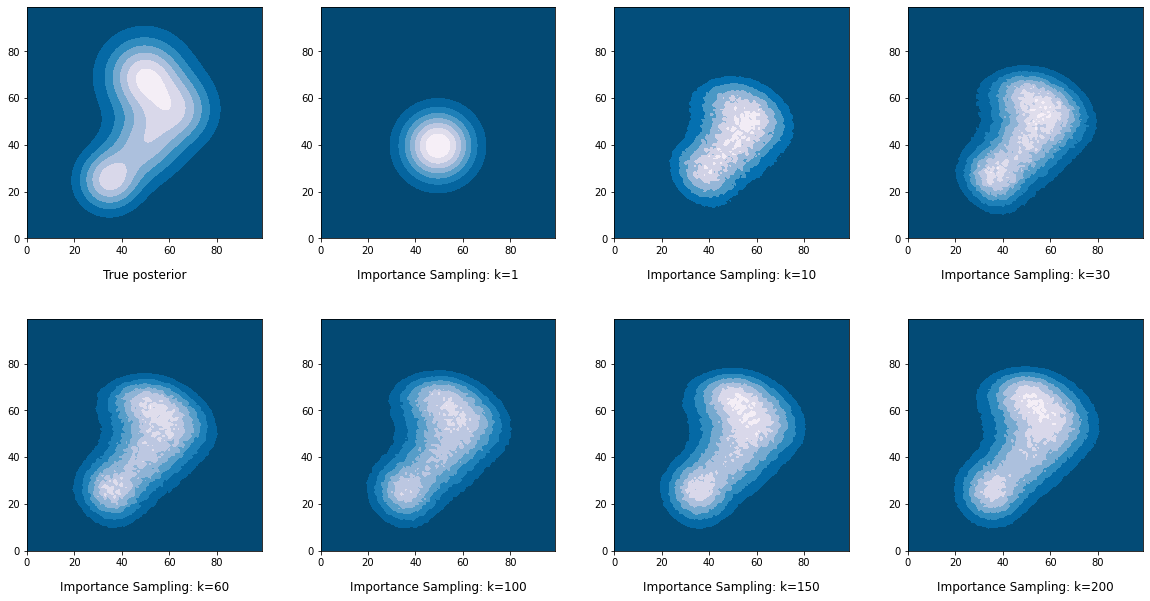

In [12]:
num_row = 2
num_col = 4

plt.rcParams['figure.figsize'] = (num_col*5.0, num_row*5.0)

fig = plt.figure()
gs = gridspec.GridSpec(num_row, num_col)
ax = []
for i in range(gs.get_geometry()[0]):
    for j in range(gs.get_geometry()[1]):
        ax.append(fig.add_subplot(gs[i, j]))
    
for i, image in enumerate(list_of_image):
    ax[i].contourf(image, cmap=cm.PuBu_r)
    if i == 0:
        ax[i].set_title('True posterior', y=-0.2)
    else:
        ax[i].set_title('Importance Sampling: k={}'.format(list_of_K[i-1]), y=-0.2)

plt.subplots_adjust(wspace=0.25, hspace=0.35)
        
plt.show()